## Creating Biased Datasets Using Simstudy

In this notebook, we will be using Simstudy to simulate a dataset in which certain outcomes are biased, conditional on certain characteristics. We aim to demonstrate how Simstudy can be used to develop accelerators, as well as Trustworthy AI demos. By specifying the relationships between inputs and outputs ahead of time, we can see how well different algorithms do at estimating these relationships.

In [1]:
cd ../

/Users/davidcruz/Desktop/pysimstudy


In [2]:
import math
import pandas as pd
import numpy as np
import random
from scipy import special
import seaborn as sns
import matplotlib.pyplot as plt

from py_scripts.generate_dist import *
from py_scripts.group_data import *
from py_scripts.define_data import *
from py_scripts.generate_data import *
from py_scripts.add_data import *
from py_scripts.asserts import *

import statsmodels.api as sm

np.random.seed(42)

def coefasProb(coef):
    return np.exp(coef) / (1 + np.exp(coef))

### Core Functions

To begin with the end in mind, our goal will be to create a dataset of a fictitious population. This population of individuals will have a region which they belong to, their standardized income, as well as whether or not they are approved for a loan.

Below is an example for defining categorical variables. In this example we are defining a categorical example named "region". 

In [3]:
df = defData(varname = "region", formula="0.333, 0.333, 0.333",
             variance="red, blue, green", dist="categorical")
             
df = defData(df, varname = "income", formula=0,
             variance=.1, dist="normal")
             
df = defData(df, varname="approval", formula='0.5', dist='binary')

df2 = genData(10000, df)

defC = defCondition(condition = "region=='blue'", formula = "0.1", variance = "0.1**2",
                    dist = "normal")

defC = defCondition(defC, condition = "region!='blue'", formula = "0", variance = "0.1**2",
                    dist = "normal")

df3 = addCondition(defC, df2, newvar="income")

In [4]:
df3.head()

,id,region,income,approval,income_condition
0,0,blue,-0.470503,0,0.245446
1,3,blue,-0.371211,0,-0.035429
2,8,blue,0.244396,1,0.181362
3,17,blue,-0.144585,0,0.243657
4,18,blue,-0.217916,0,-0.090722


In [5]:
df3.groupby('region').mean()

,id,income,approval,income_condition
region,,,,
blue,5046.184901,0.006262,0.504276,0.098561
green,4941.379864,-0.002396,0.496294,-0.001759
red,5008.365174,0.007593,0.487392,-0.001162


In [6]:
df = defData(varname = "color", formula="0.333, 0.333, 0.333",
             variance="red, blue, green", dist="categorical")
             
df = defData(df, varname = "income", formula=0,
             variance=1, dist="normal")
             
df = defData(df, varname="approval", formula='0.5', dist='binary')

df2 = genData(10000, df)

defC = defCondition(condition = "color=='blue'", formula = "0.4+income/10",
                    dist = "binary")

defC = defCondition(defC, condition = "color!='blue'", formula = "0.5+income/10",
                    dist = "binary")

df3 = addCondition(defC, df2, newvar="approval_bias")

In [7]:
df3

,id,color,income,approval,approval_bias
0,0,blue,0.006596,1,0
1,2,blue,-0.455134,0,0
2,3,blue,0.883805,0,0
3,8,blue,0.199709,0,0
4,10,blue,0.846566,1,0
...,...,...,...,...,...
9995,9990,red,-0.736187,1,0
9996,9991,red,-0.511304,1,1
9997,9992,green,1.793959,0,1
9998,9994,green,-0.516907,1,0


<AxesSubplot:xlabel='approval_bias', ylabel='Count'>

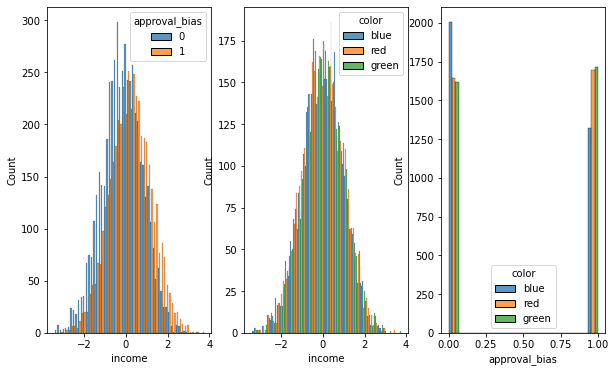

In [8]:
fig, ax = plt.subplots(1,3, figsize = (10,6))
sns.histplot(
    data=df3, x='income', hue='approval_bias', multiple='dodge',
    # bins=range(1, 110, 10),
    ax=ax[0]
)

sns.histplot(
    data=df3, x='income', hue='color', multiple='dodge',
    # bins=range(1, 110, 10),
    ax=ax[1]
)

sns.histplot(
    data=df3, x='approval_bias', hue='color', multiple='dodge',
    # bins=range(1, 110, 10),
    ax=ax[2]
)

In [9]:
df3.groupby('approval_bias')['income'].mean()

approval_bias
0   -0.178115
1    0.199585
Name: income, dtype: float64

In [10]:
df2.groupby('color')['income'].mean()

color
blue    -0.006735
green    0.012236
red     -0.003792
Name: income, dtype: float64

In [11]:
df3.groupby('color')['approval_bias'].value_counts(normalize=True)

color  approval_bias
blue   0                0.602888
       1                0.397112
green  1                0.514843
       0                0.485157
red    1                0.507034
       0                0.492966
Name: approval_bias, dtype: float64

In [12]:
import statsmodels.api as sm

In [13]:
df3['const'] = 1

In [14]:
mod = sm.GLM(df3['approval_bias'], pd.get_dummies(df3.drop(['id', 'approval_bias'], axis = 1)),
family=sm.families.Binomial())
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          approval_bias   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6673.5
Date:                Thu, 13 Oct 2022   Deviance:                       13347.
Time:                        16:01:21   Pearson chi2:                 9.99e+03
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
income          0.3987      0.021     18.661      

In [15]:
# the coefficient of red as a probability
coefasProb(0.1274)

0.5318069906639059

## Case Study 2: Scenario 1 - Coding direct Bias into a Dataset

In [16]:
# we begin with the variable that we want to directly show bias. in this case it is Region.
df = defData(varname = "region", formula="0.33, 0.33, 0.33",
             variance="red, blue, green", dist="categorical")
# Income will be normally distributed across the entire population             
df = defData(df, varname = "income", formula=0,
             variance=.1**2, dist="normal")
# the approval rating is the variable which will reflect bias based on which region a person is from.
# We set it up with a binary distribution to simulate 0 for not approved, and 1 for approved
df = defData(df, varname="approval", formula='0.5+income', dist='binary')

# generate 10000 data points
df2 = genData(10000, df)
# Conditions are where we begin to hard-code biases into the data set.
# The blue region will have a mean centered around a lower
# value when compared to the other regions
# defCondition holds one or more conditions that we will apply to our dataset to create bias.
defC = defCondition(condition = "region=='blue'", formula = "0.4+income",
                    dist = "binary")
# If a person is not from the blue region, the mean for approval is 
defC = defCondition(defC, condition = "region!='blue'", formula = "0.5+income",
                    dist = "binary")

df3 = addCondition(defC, df2, newvar="approval_bias")

In [17]:
df3.head()

,id,region,income,approval,approval_bias
0,4,blue,-0.047069,1,1
1,10,blue,0.059795,0,0
2,12,blue,0.098250,1,0
3,14,blue,0.031213,0,0
4,15,blue,-0.028204,0,0


In [18]:
df3.groupby('region')['approval'].value_counts(normalize=True)

region  approval
blue    1           0.508382
        0           0.491618
green   0           0.507660
        1           0.492340
red     1           0.501770
        0           0.498230
Name: approval, dtype: float64

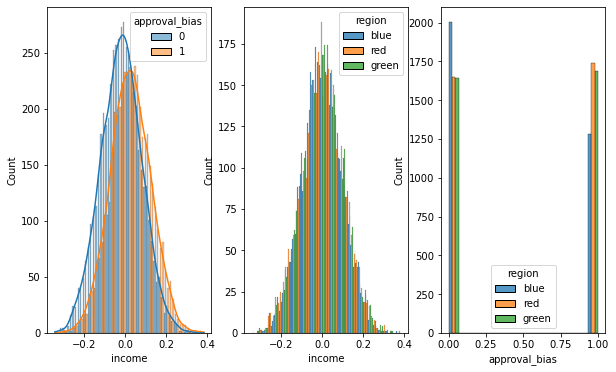

In [19]:
fig, ax = plt.subplots(1,3, figsize = (10,6))
sns.histplot(
    data=df3, x='income', hue='approval_bias', multiple='dodge',
   # bins=range(1, 110, 10),
    ax=ax[0], kde = True
)

sns.histplot(
    data=df3, x='income', hue='region', multiple='dodge',
   # bins=range(1, 110, 10),
    ax=ax[1]
)

sns.histplot(
    data=df3, x='approval_bias', hue='region', multiple='dodge',
    #bins=range(1, 110, 10),
    ax=ax[2]
);

In [20]:
df3['const'] = 1
mod = sm.GLM(df3['approval_bias'], pd.get_dummies(df3.drop(['id', 'approval_bias'], axis = 1)),
family=sm.families.Binomial())
res = mod.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          approval_bias   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9995
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6594.5
Date:                Thu, 13 Oct 2022   Deviance:                       13189.
Time:                        16:01:23   Pearson chi2:                 9.99e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
income           4.6958      0.220     21.376   

In [21]:
# the coefficient of blue as a prb
coefasProb(-0.3194)

0.4208219794045014

In [22]:
# the coefficient of red as a prb
coefasProb(0.0854)

0.5213370337092745

In [23]:
# the coefficient of green as a prob
coefasProb(0.1364)

0.5340472290832388

## Case Study 2: Scenario 2 - Coding indirect Bias into a Dataset

In [53]:
df = defData(varname = "region", formula="0.33, 0.33, 0.33",
             variance="red, blue, green", dist="categorical")

df4x = genData(10000, df)

defIncome = defCondition(condition = "region=='blue'", 
                    formula = 0.1,
                    variance = .1**2,
                    dist = "normal")

defIncomeBiased = defCondition(defIncome, condition = "region!='blue'", 
                    formula = .2,
                    variance = .1**2,
                    dist = "normal")

df5 = addCondition(defIncome, df4x, newvar="income_raw")
df5 = addCondition(defIncomeBiased, df4x, newvar="income_biased")
dfadd = defDataAdd(varname="approval", formula='0.5', dist='binary' )

In [54]:
df5

,id,region,income_biased
0,4,blue,0.196396
1,6,blue,-0.017932
2,8,blue,0.011442
3,10,blue,-0.000533
4,16,blue,0.219149
...,...,...,...
9995,9992,green,0.190066
9996,9993,red,0.187951
9997,9995,red,0.176401
9998,9998,green,0.301838


In [43]:
df5.groupby('region')['income_biased'].value_counts()

region  income_biased
blue    -0.281421        1
        -0.223531        1
        -0.205506        1
        -0.201512        1
        -0.195349        1
                        ..
red      0.503346        1
         0.509256        1
         0.509724        1
         0.535961        1
         0.563708        1
Name: income_biased, Length: 10000, dtype: int64

In [44]:
df5.groupby('region')['income_biased'].mean()

region
blue     0.098716
green    0.201916
red      0.202167
Name: income_biased, dtype: float64

In [55]:
m = df5['income_biased'].mean()
s = df5['income_biased'].std()
df5['income_standard'] = df5['income_biased'].apply(lambda x: (x - m) / s)

In [56]:
df5.groupby('region')['income_standard'].mean()

region
blue    -0.610236
green    0.290233
red      0.301271
Name: income_standard, dtype: float64

Income is the only factor directly influencing approval

In [57]:
defTarget =  defData(varname = "approval", dist = "binary", formula = "0.5+(income_biased/10)",)
defTarget

,varname,formula,variance,dist,link
0,approval,0.5+(income_biased/10),0,binary,identity


But, income is biased based on previous conditions

In [58]:
df5 = addColumns(defTarget, df5)

In [59]:
df5

,id,region,income_biased,income_standard,approval
0,4,blue,0.196396,0.270327,1
1,6,blue,-0.017932,-1.664677,1
2,8,blue,0.011442,-1.399477,0
3,10,blue,-0.000533,-1.507589,0
4,16,blue,0.219149,0.475745,1
...,...,...,...,...,...
9995,9992,green,0.190066,0.213175,1
9996,9993,red,0.187951,0.194084,1
9997,9995,red,0.176401,0.089810,0
9998,9998,green,0.301838,1.222280,1


In [60]:
df5.groupby('region')['approval'].value_counts(normalize=True)

region  approval
blue    1           0.510417
        0           0.489583
green   1           0.529394
        0           0.470606
red     1           0.527295
        0           0.472705
Name: approval, dtype: float64

In [ ]:
df5.groupby('education')['approval'].value_counts(normalize=True)

In [ ]:
df5['const'] = 1
mod = sm.GLM(df5['approval'], pd.get_dummies(df5.drop(['id', 'approval', 'income_raw', 
            'income_biased', 'income_biased2'], axis = 1)),
            family=sm.families.Binomial())
res = mod.fit()
print(res.summary())

In [ ]:
coefasProb(-0.0563)

In [ ]:
coefasProb(0.0305)

In [ ]:
coefasProb(0.0075)

### Scenario 3: 

In [ ]:
df = defData(varname = "region", formula="0.55, 0.10, 0.35",
             variance="red, blue, green", dist="categorical")

df = defData(df, varname = "gender", formula=0.5,
            dist="binary")
             
df2 = genData(10000, df)

defNeighborhood = defCondition(condition = "region=='blue'", 
                    formula = "0.75, 0.05, 0.05, 0.15",
                    variance = "N1, N2, N3, N4",
                    dist = "categorical")

defNeighborhood = defCondition(defNeighborhood, condition = "region=='red'", 
                    formula = "0.05, 0.55, 0.2, 0.2",
                    variance = "N1, N2, N3, N4",
                    dist = "categorical")

defNeighborhood = defCondition(defNeighborhood, condition = "region=='green'", 
                    formula = "0.2, 0.4, 0.3, 0.1",
                    variance = "N1, N2, N3, N4",
                    dist = "categorical")

defEdu = defCondition(condition = "region=='blue'", 
                    formula = "0.65, 0.25, 0.1",
                    variance = "e1, e2, e3",
                    dist = "categorical")

defEdu = defCondition(defEdu, condition = "region=='red'", 
                    formula = "0.2, 0.3, 0.5",
                    variance = "e1, e2, e3",
                    dist = "categorical")

defEdu = defCondition(defEdu, condition = "region=='green'", 
                    formula = "0.3, 0.4, 0.3",
                    variance = "e1, e2, e3",
                    dist = "categorical")

defIncome = defCondition(condition = "education=='e1'", 
                    formula = 500,
                    variance = 100**2,
                    dist = "normal")

defIncome = defCondition(defIncome, condition = "education=='e2'", 
                    formula = 750,
                    variance = 125**2,
                    dist = "normal")

defIncome = defCondition(defIncome, condition = "education=='e3'", 
                    formula = 1500,
                    variance = 250**2,
                    dist = "normal")

defIncomeBiased = defCondition(condition = "region=='blue'", 
                    formula = "0.9*income_raw",
                    dist = "nonrandom")

defIncomeBiased = defCondition(defIncomeBiased, condition = "region!='blue'", 
                    formula = "income_raw",
                    dist = "nonrandom")

defIncomeBiasedGender = defCondition(condition = "gender==0", 
                        formula = "0.95*income_biased",
                        dist = "nonrandom")

defIncomeBiasedGender = defCondition(defIncomeBiasedGender, condition = "gender==1", 
                        formula = "income_biased",
                        dist = "nonrandom")

df3 = addCondition(defNeighborhood, df2, newvar="neighborhood")
df3 = addCondition(defEdu, df3, newvar="education")
df3 = addCondition(defIncome, df3, newvar="income_raw")
df3 = addCondition(defIncomeBiased, df3, newvar="income_biased")
df3 = addCondition(defIncomeBiasedGender, df3, newvar="income_biased2")

In [ ]:
df3['const'] = 1
mod = sm.GLM(df3['approval'], pd.get_dummies(df3.drop(['id', 'approval', 'income_raw', 'eye_color',
            'income_biased', 'income_biased2'], axis = 1)),
            family=sm.families.Binomial())
            
res = mod.fit()
print(res.summary())

In [ ]:
df3.columns

In [ ]:
pd.get_dummies(df3.drop(['id', 'approval', 'income_raw', 
            'income_biased', 'income_biased2'], axis = 1))

In [ ]:
from sklearn.utils import compute_sample_weight, resample

from sklearn.model_selection import  train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV, RidgeClassifier, RidgeClassifierCV, LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
# from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import tree

from sklearn.metrics import classification_report, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

In [ ]:
X = df3.drop(['id', 'approval', 'income_raw',
            'income_biased', 'income_biased2'], axis = 1)

In [ ]:
y = df3['approval']

In [ ]:
# establish categorical variables in X
categorical = X.dtypes == object
# preprocessing pipeline
preprocess = make_column_transformer(
    (StandardScaler(), ~categorical),
    (OneHotEncoder(handle_unknown = 'ignore'), categorical)
)

cv = KFold(n_splits = 5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = make_pipeline(preprocess, LogisticRegression())
model.fit(X_train, y_train);

In [ ]:
cat_names = ['eye_color', 'neighborhood', 'education']
final_feature_names = categorical[~categorical].index.values.tolist() + \
                      preprocess.transformers_[1][1].get_feature_names_out(cat_names).tolist()

coefs = model.named_steps['logisticregression'].coef_[0]

featureImportance_df = pd.Series(data = coefs, 
                                 index = final_feature_names, 
                                 name = 'coefs').\
                        sort_values(ascending = False, key = np.abs)

In [ ]:
# setting a y_axis variable allows to flip chart for easier reading        
yax = np.arange(len(featureImportance_df))

fig, ax = plt.subplots(1, 1, figsize = (8,8))

ax.plot(featureImportance_df, yax, 'o', c='r')
ax.set_yticks(range(len(featureImportance_df)))
ax.yaxis.tick_right()
ax.set_yticklabels(featureImportance_df.index,rotation = 0)
ax.set_title('lasso'.capitalize()+' Coefficients\nTarget Variable Name: '+str(y.name))
ax.axvline(0)

plt.show()

In [ ]:
df3[df3['eye_color'] == 'blue']['neighborhood'].value_counts(normalize=True)

In [ ]:
X_train

In [ ]:
X_train['gender'].value_counts()[X_train['gender'].value_counts() > 1].reset_index()['gender']

In [ ]:
y_pred = model.predict(X_test)